# Simulation of Transmission Loss

In [71]:
import pyat
from pyat_tools import pyat_tools
import xarray as xr
import pandas as pd
import numpy as np
from numpy import matlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pickle
from tqdm import tqdm
import scipy
from geopy.distance import geodesic
from oceans.sw_extras import sw_extras as sw
from sklearn.linear_model import LinearRegression
import hvplot.xarray
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Open sound speed data
fdir = '/datadrive/HYCOM_data/Axial_Seamount_earthengine/*.nc'
ds = xr.open_mfdataset(fdir)
time_coord = pd.to_datetime(np.arange(pd.Timestamp('2015-01-01').value, pd.Timestamp('2023-01-01').value, 1e9*3600*24))
ds_interp = ds.interp(time=time_coord).compute()
ssp_full = sw.soundspeed(ds_interp.salinity, ds_interp.temperature, ds.depth)[:,:-5]

In [4]:
TLs = []
for k in tqdm(range(ssp_full.shape[0])):

    ssp_hycom = pyat_tools.convert_SSP_arlpy(ssp_full, k)[1:,:]
    
    # Fit linear regression model for deeper sound speeds
    ssp_segment = ssp_full[k].loc[600:]
    y=ssp_segment.values
    X=ssp_segment.depth.values.reshape(-1,1)
    reg = LinearRegression().fit(X,y)
    
    deep_depths = np.array([1519, 1528, 1600])
    deep_ssps = reg.predict(deep_depths.reshape(-1,1))
    
    ssp = np.vstack((ssp_hycom, np.vstack((deep_depths, deep_ssps)).T))

    # sound speed ratio for rough rock is 2.5
    cb = 2.5*ssp[-3,1]
    
    fn = 'kraken_files/caldera_surface_TL'
    pyat_tools.write_env_file_pyat(ssp, 1519, 1, np.linspace(0,5,1000), np.array([1519.5]), 5, 'caldera_surface_TL', fn=fn, verbose=False, cb=cb)

    # Write field flp file
    s_depths = np.array([1])  # meters
    ranges = np.linspace(0,5,1000)  # km
    r_depths = np.array([1519.5])  # meters
    
    pyat_tools.write_flp_file(s_depths, ranges, r_depths, fn, verbose=False)
    
    # Run Kraken and Field
    os.system('kraken.exe kraken_files/caldera_surface_TL > /dev/null 2>&1')
    os.system('field.exe kraken_files/caldera_surface_TL > /dev/null 2>&1')
    p = pyat.pyat.readwrite.read_shd('kraken_files/caldera_surface_TL.shd')[5]
    
    TLs.append(p)

100%|█████████████████████████████████████████████████████████████████████████████| 2922/2922 [01:28<00:00, 32.97it/s]


In [5]:
TLs = np.array(TLs)[:,0,0,0,:]

In [13]:
TLs_x = xr.DataArray(TLs, dims=['time','range'], coords={'time':ssp_full.time, 'range':ranges}, name='Transmission Loss')

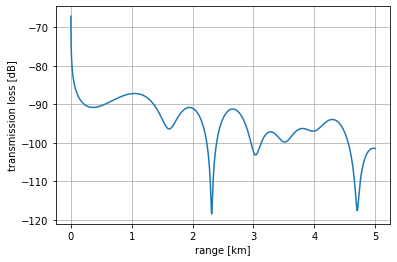

In [10]:
r = np.linspace(0,5,1000)
plt.plot(r, 20*np.log10(np.abs(TLs[2,:])))
plt.xlabel('range [km]')
plt.ylabel('transmission loss [dB]')
plt.grid()

Text(0.5, 0, '')

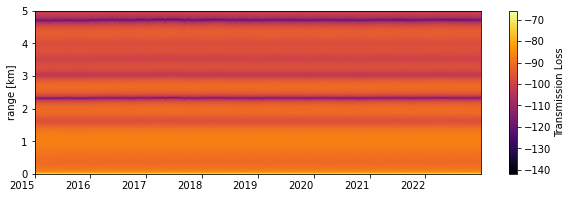

In [42]:
fig = plt.figure(figsize=(10,3))
(20*np.log10(np.abs(TLs_x))).plot(x='time', cmap='inferno')
plt.ylabel('range [km]')
_ = plt.xticks(rotation=0)
plt.xlabel('')

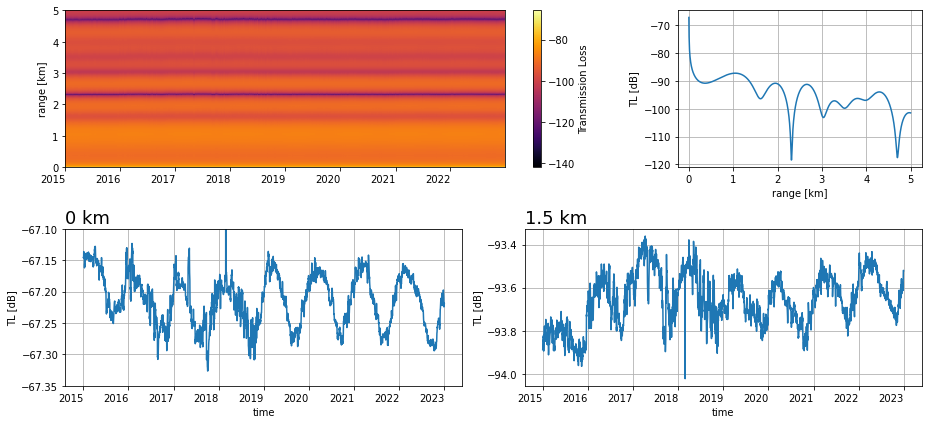

In [86]:
gs = gridspec.GridSpec(2,6)

fig = plt.figure(figsize=(13,6))

ax1 = fig.add_subplot(gs[0,:4])
ax2 = fig.add_subplot(gs[0,4:])
ax3 = fig.add_subplot(gs[1,:3])
ax4 = fig.add_subplot(gs[1,3:])

plt.sca(ax1)
TL_plot = (20*np.log10(np.abs(TLs_x))).plot(x='time', cmap='inferno')
TL_plot.set_rasterized(True)

plt.ylabel('range [km]')
_ = plt.xticks(rotation=0)
plt.xlabel('')

plt.sca(ax2)
r = np.linspace(0,5,1000)
plt.plot(r, 20*np.log10(np.abs(TLs[2,:])))
plt.xlabel('range [km]')
plt.ylabel('TL [dB]')
plt.grid()

plt.sca(ax3)
(20*np.log10(np.abs(TLs_x.sel({'range':0}, method='nearest')))).plot()
plt.title('')
plt.title('0 km', loc='left', fontsize=18)
plt.grid()
plt.ylim([-67.35, -67.1])
_ = plt.xticks( rotation=0)
plt.ylabel('TL [dB]')

plt.sca(ax4)
(20*np.log10(np.abs(TLs_x.sel({'range':1.5}, method='nearest')))).plot()
plt.grid()
plt.title('')
plt.title('1.5 km', loc='left', fontsize=18)
_ = plt.xticks(rotation=0)
plt.ylabel('TL [dB]')

plt.tight_layout()

fig.savefig('figures/TL.svg', dpi=300)

In [85]:
TL_plot

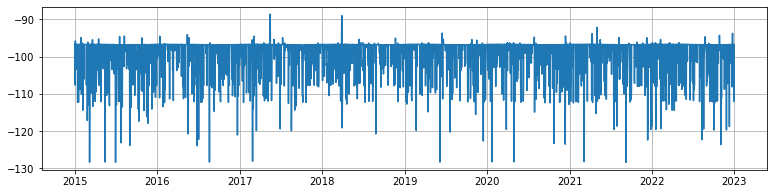

In [106]:
fig = plt.figure(figsize=(13,3))
plt.plot(ssp_full.time, 20*np.log10(np.abs(TLs[:,800])))
plt.grid()
#plt.ylim([-67.35, -67.1])

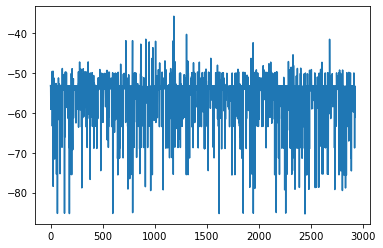

In [107]:
plt.plot(20*np.log10(np.abs(np.sum(TLs, axis=1))))